# **Framework Improvements & Adding The Learner Class**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle, gzip, math, os, time, shutil
import fastcore.all as fc
from operator import attrgetter, itemgetter
from functools import partial
from collections.abc import Mapping
from contextlib import contextmanager
from pathlib import Path
from copy import copy

import torch
from torch import nn, tensor, optim
from torch.utils.data import default_collate, DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

from miniai.training import * # Modules have already been developed in previous NBs
from miniai.datasets import * # and, reside in separate Github repo.
from miniai.conv import *
from fastprogress import progress_bar, master_bar

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=14, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging 
logging.disable(logging.WARNING)

## **The Learner**

The objective of this new class will be to:
1. Enable rapid testing of new approaches wrt the modeling process, especially on the training and inference fronts.
2. Constantly build on-top of the existing learner's functionality.
3. Allow improved inspection, optimized CUDA implementations etc.

So, let's get the HuggingFace `Fashion_MNIST` dataset again.

In [3]:
x, y = 'image', 'label'
name  = "fashion_mnist"
dsd = load_dataset(name)

In [4]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [6]:
bs = 1024
tds = dsd.with_transform(transformi)

In [7]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 784]),
 tensor([5, 4,
         9, 4,
         3, 0,
         6, 5,
         7, 6]))

The Leaner's purpose is to replace the `fit` function. This class incorporates the following functionality:

1. Train a model using a variety of architectures.
2. Use a particular set of dataloaders and loss functions.
3. Define a learning rate.
4. Use a predefined or custom optimization function.

In [8]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): 
        # fastcore store_attr() reduces the amount of boilerplate that usually goes
        # into an __init__() constructor.
        fc.store_attr()

    def one_batch(self):
        # Load batch onto device
        self.xb, self.yb = to_device(self.batch)
        # Call the model and the loss function
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        # Carry out training and calculate stats if mode=training
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        # Set model mode
        self.model.training = train
        # Select training or validating set and call one_batch()
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        # Track accuracy, loss etc
        self.accs, self.losses,self.ns = [], [], []
        self.model.to(def_device)
        # Create optim and store the num of epochs
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        # For each epoch, call the one epoch function
        for self.epoch in range(n_epochs):
            self.one_epoch(True)                        # If training
            with torch.no_grad(): self.one_epoch(False) # If evaluating

We can test the new learner on the simple MLP. 

In [9]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [10]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.1753046875 0.5986833333333333
0 False 1.1203290178571428 0.6135285714285714


While the Learner works for an MLP, it lacks the flexibility to handle more complex architectures like AutoEncoders, Deep ConvNets etc.

## **Basic Callbacks Learner**

In [11]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [12]:
# Base callback class with default order of 0
class Callback(): order = 0

In [13]:
def run_cbs(cbs, method_nm, learn=None):
    # Loop through each callback and sort them by their order attribute.
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn) # Run method by order

In [14]:
# Simple callback which updates counts based on the model's training runs.
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [15]:
# Demo
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


Now we can use additional callbacks to extend our demo. These callbacks will be added at key points within the Learner.

Any one of these new callbacks i.e. `before_fit`, `after_fit`, `before_batch`, `after_batch`, `before_epoch` and `after_epoch` can raise the following exceptions.

- `CancelFitException`
- `CancelBatchException`
- `CancelEpochException`

Also, the use of `self.` throughout the Learner means that those objects or processes are modifiable using callbacks. The `__init__()` constructor basically allows the callback attribute `cb.learn` to be set equal to the learner. So, later on, we will be able to use `self.learn.model` in a callback class to access the Learner directly.

In [16]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): 
        # Takes a function method_nm and runs callbacks.
        run_cbs(self.cbs, method_nm, self)

In [17]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [18]:
model = get_model()
# The model will return the results from the Completion Callback above.
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


In [19]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [20]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

## **Metrics**

As the framework begins to take shape, we won't be working exclusively with `Cross Entropy` loss. This is because the framework is supposed to be flexible for a wide range of deep learning problems, be they generative or otherwise.

With this in mind, let's create a `Metrics` class. Here, we will also introduce the concept of [Sub-classing](https://llego.dev/posts/in-depth-guide-superclasses-subclasses-python/), which will allow us to calculate various metrics while increasing flexibility:

> Superclasses and subclasses are key concepts in object-oriented programming that allow code reuse through inheritance. A superclass, also called a base class or parent class, contains attributes and methods that are common to a set of related classes. A subclass, also known as a derived class or child class, inherits from the superclass and specializes or extends its capabilities.

In [21]:
class Metric:
    def __init__(self): self.reset()

    def reset(self): 
        # Reset at the start of each epoch
        self.vals, self.ns = [], []

    def add(self, inp, targ=None, n=1): # n = number of items in the mini-batch
        # Adds mini batches of data and call calculate
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)

    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum() / ns.sum()

    def calc(self, inps, targ): return inps

Here, `Accuracy` is the subclass of `Metric`. Whats happening under the hood is that `calc()`, when it is called in `Accuracy`, basically uses the code from the `Metric` class and runs its own version of the function instead of the parent / super-class's version.

In [22]:
class Accuracy(Metric):
    # The sub-class runs this version of calc() instead of the parent's version.
    def calc(self, inps, targs): return  (inps==targs).float().mean()

In [23]:
# For demonstration purposes, creating some random inputs and predictions
acc = Accuracy()
# Each call to add() stores the  inputs and predictions
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
# Here value is a property of Metric
acc.value

tensor(0.45)

In [24]:
# In contrast to Accuracy(), Metric() will, by default, calculate the weighted average of whatever is passed.
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)

loss.value, round((0.6*32 + 0.9*2) / (32+2), 2)

(tensor(0.62), 0.62)

## **Some Callbacks - On the Way to Creating a Flexible Learner**

While the option certainly exists, we won't actually _need_ to write each metric class since most metrics already exist in PyTorch or its extended libraries / projects.

With that in mind, we will use **[TorchEval](https://pytorch.org/torcheval/stable/torcheval.metrics.html)** moving forward.

In [25]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [26]:
# Testing torcheval methods
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [27]:
# Our reset function above does the exact same thing
metric.reset()
metric.compute()

tensor(nan)

In [28]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k, v in x.items()}
    if isinstance(x, list): return[to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [29]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o # if positional args are passed then grab the name from the type
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    
    def before_fit(self, learn): learn.metrics = self # learner will start recording metrics
        
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch) # grab both input and target
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

Earlier on, we encountered errors when we first tried to increase the number of processes for our dataloaders. This callback, when fully built, will allow us to address such issues at the `before_fit` and the `before_batch` stages.

In [30]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): 
        # Option to change devices
        fc.store_attr()

    def before_fit(self, learn):
        # Before fitting, load model onto device
        if hasattr(learn.model, 'to'): learn.model.to(self.device)

    def before_batch(self, learn): 
        # Before each batch, load batch onto device
        learn.batch = to_device(learn.batch, device=self.device)

In [31]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.602', 'loss': '1.183', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.700', 'loss': '0.847', 'epoch': 0, 'train': 'eval'}


## **Moving to a Flexible Learner**

This update, while being more advanced and flexible than previous versions of the Learner, shortens both the `one_epoch` and `fit` functions through the use of the `@contextmanager` decorator.

Reduction in code duplication is the primary goal here.

In [32]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try: # Putting the callbacks in try / except blocks allows for flow control
            self.callback(f'before_{nm}')
            yield # call all blocks for before_epoch, before_fit and before_batch
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'): # Refer to @contextmanager above
            for self.iter, self.batch in enumerate(self.dl):
                # Using a context manager here allows us to call the functions while defining them separately
                # hence more flexibility. These funcs will call __getattr__()
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # Reference NB 11 and 12 for `add_cb` and `rm_cb`
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'): # Refer to @contextmanager above
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        # When the following func. names are called in one epoch, don't raise an error.
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self): return self.model.training

With the addition of the context manager and simplification of the `one_epoch()` function, we can create a new callback which executes `predict()`, `get_loss()`, `backward()`, `step()` and `zero_grad()` - while refactoring the code. 

The `TrainCB()` callback can be edited to add compatibility with HuggingFace Accelerate or other platforms and frameworks. 

In [37]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp # We can train with more than one input
    
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])

    def backward(self, learn): learn.loss.backward()

    def step(self, learn): learn.opt.step()

    def zero_grad(self, learn): learn.opt.zero_grad()

Let's create a progress bar as well.

In [42]:
class ProgressCB(Callback):
    order = MetricsCB.order+1

    def __init__(self, plot=False): self.plot = plot

    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log # overwrite learner _log() with ProgressCB._log()
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)

    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],
                                                        [fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), 
                                                         self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],
                                        [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), 
                                         self.val_losses]])

In [47]:
model = get_model()

accuracy,loss,epoch,train
0.609,1.164,0,train
0.702,0.802,0,eval
0.741,0.721,1,train
0.766,0.658,1,eval
0.780,0.621,2,train
0.791,0.582,2,eval
0.799,0.569,3,train
0.796,0.567,3,eval
0.810,0.537,4,train
0.802,0.543,4,eval


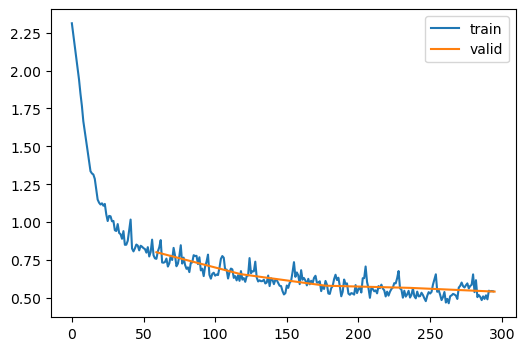

In [48]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

### **Additional Modifications to the Flexible Learner - to do**

## **TrainLearner and Momentum Learner - Using Subclasses Instead of Callbacks** 

Notice that we don't need to call `self.learn.{}` like we did in the callbacks. We can call `self.{}` since `TrainLearner` will be a subclass of `Learner`. 

In [52]:
class TrainLearner(Learner): # subclassing
    def predict(self): self.preds = self.model(self.batch[0])

    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])

    def backward(self): self.loss.backward()

    def step(self): self.opt.step()

    def zero_grad(self): self.opt.zero_grad()

Recall that the default implementation of `zero_grad()` zeros the gradients. We can now overwrite that function, using a new subclass called `MomentumLearner`, to retain the gradients while multiplying them with a new parameter `momentum`. **[Here](https://paperswithcode.com/method/sgd-with-momentum)** is a quick review of the concept.

In [54]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad(): 
            # Using the grads directly makes this a leaner implementation than standard momentum 
            for p in self.model.parameters(): p.grad *= self.mom

These blocks allow us to effectively get rid of the `TrainCB` callback.

accuracy,loss,epoch,train
0.684,0.934,0,train
0.797,0.577,0,eval
0.820,0.515,1,train
0.825,0.503,1,eval
0.842,0.458,2,train
0.833,0.468,2,eval
0.847,0.437,3,train
0.827,0.492,3,eval
0.856,0.413,4,train
0.850,0.430,4,eval


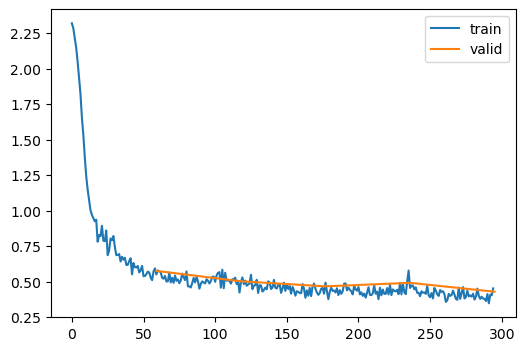

In [51]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(5)

## **LR Finder from FastAI**

In [55]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()

    def before_fit(self, learn):
        self.lrs, self.losses = [], []
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

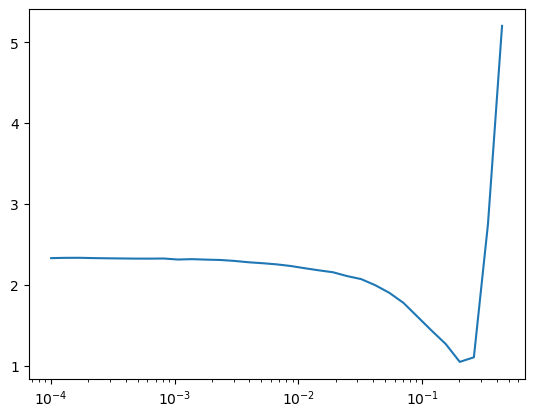

In [57]:
lrfind = LRFinderCB() # instantiating so that we can grab the losses and learning rates
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

### **Add PyTorch's `LR_Scheduler` to `LRFinderCB`**

In [58]:
from torch.optim.lr_scheduler import ExponentialLR

In [59]:
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()

    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs, self.losses = [], []
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult): 
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

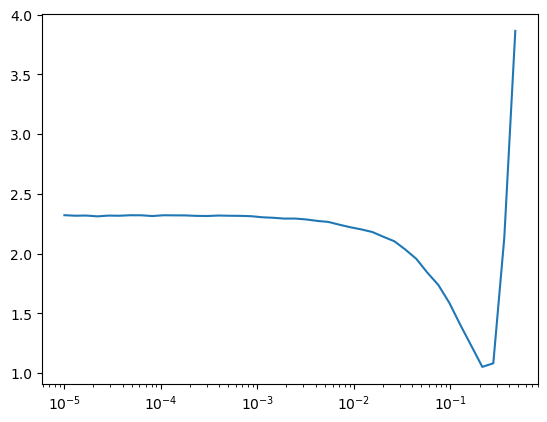

In [60]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())